# Time-Series Analysis using Kats (SARIMA, Prophet): Dhaka Tribune

## Highlights

* Dataset: Dhaka Tribune 2021 Dataset.

Author: Sumaia Parveen Shupti

Created on: 07/07/2021

Updated on: 07/31/2021

In [1]:
#!pip install kats

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from datetime import datetime, timedelta
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
#import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)
import sys
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore')
sys.path.append("../")

from kats.consts import TimeSeriesData

### Load & Preprocess Dataset

In [3]:
df = pd.read_csv('../input/dhakatribunecomplete/Dhaka Tribune Complete Data.csv')
df['Accident date'] = pd.to_datetime(df['Accident date'])

df = df[['Accident date', 'Deaths']]
df.columns = ['Period', 'Deaths']
df = df.sort_values(by = 'Period')
df = df.reset_index(drop = True).set_index('Period').resample('1W').sum()
df = df.reset_index()
df['Period'] = df['Period'].dt.date
df['Deaths'] = df['Deaths'].fillna(0)
#df = df.set_index('Period')
df

,Period,Deaths
0,2016-06-26,3.0
1,2016-07-03,0.0
2,2016-07-10,0.0
3,2016-07-17,4.0
4,2016-07-24,0.0
...,...,...
257,2021-05-30,3.0
258,2021-06-06,11.0
259,2021-06-13,8.0
260,2021-06-20,16.0


In [4]:
start_ = df.Period.max()
end_ = df.Period.min()

test_end = df.Period.max()
test_start = df.Period.max() - timedelta(days = 60)

train_end = test_start - timedelta(days = 1)
train_start = train_end - timedelta(days = 365*5)

print('Dataset Start Date: {}'.format(start_))
print('Dataset End Date: {}'.format(end_))
print (' ')
print('Train Set Start Date: {}'.format(train_start))
print('Train Set End Date: {}'.format(train_end))
print (' ')
print('Test Set Start Date: {}'.format(test_start))
print('Test Set End Date: {}'.format(test_end))
print (' ')

Dataset Start Date: 2021-06-27
Dataset End Date: 2016-06-26
 
Train Set Start Date: 2016-04-28
Train Set End Date: 2021-04-27
 
Test Set Start Date: 2021-04-28
Test Set End Date: 2021-06-27
 


In [5]:
mask = (df.Period > train_start) & (df.Period <= train_end)
train = df.loc[mask]
#train = train.drop('Period', 1)
#train = train.drop('Date', 1)

mask = (df.Period >= test_start) & (df.Period <= test_end)
test = df.loc[mask]
#test = test.drop('Period', 1)
#test = test.drop('Date', 1)

In [6]:
train

,Period,Deaths
0,2016-06-26,3.0
1,2016-07-03,0.0
2,2016-07-10,0.0
3,2016-07-17,4.0
4,2016-07-24,0.0
...,...,...
248,2021-03-28,26.0
249,2021-04-04,7.0
250,2021-04-11,4.0
251,2021-04-18,25.0


In [7]:
len(test)

9

In [8]:
test

,Period,Deaths
253,2021-05-02,12.0
254,2021-05-09,11.0
255,2021-05-16,20.0
256,2021-05-23,28.0
257,2021-05-30,3.0
258,2021-06-06,11.0
259,2021-06-13,8.0
260,2021-06-20,16.0
261,2021-06-27,5.0


In [9]:
_df = train.copy()
_df.columns = ["time", "value"]
_ts = TimeSeriesData(_df)

### SARIMA Modelling

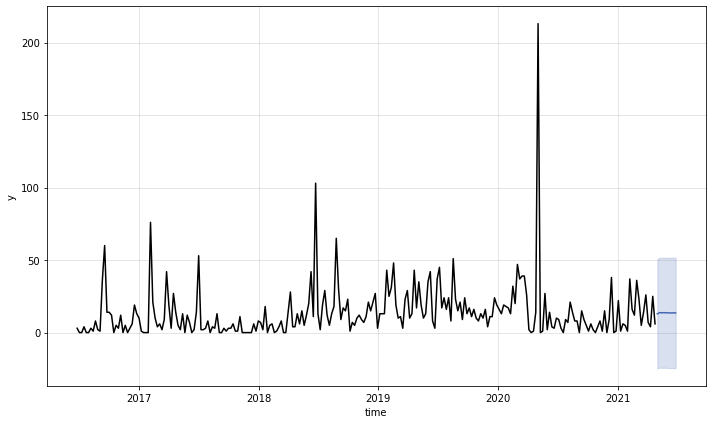

In [10]:
from kats.models.sarima import SARIMAModel, SARIMAParams
warnings.simplefilter(action='ignore')

# create SARIMA param class
params = SARIMAParams(
    p = 2, 
    d=1, 
    q=1, 
    trend = 'ct', 
    seasonal_order=(1,0,1,12)
    )

# initiate SARIMA model
m = SARIMAModel(data=_ts, params=params)

# fit SARIMA model
m.fit()

# generate forecast values
fcst = m.predict(
    steps=9, 
    freq="1W"
    )

# make plot to visualize
m.plot()

In [11]:
fcst

,time,fcst,fcst_lower,fcst_upper
253,2021-05-02,12.902633,-24.799574,50.604840
254,2021-05-09,13.758353,-24.182879,51.699585
255,2021-05-16,13.654663,-24.292087,51.601412
256,2021-05-23,13.737084,-24.225632,51.699800
257,2021-05-30,13.651083,-24.331209,51.633374
258,2021-06-06,13.546638,-24.455206,51.548481
259,2021-06-13,13.578668,-24.442631,51.599967
260,2021-06-20,13.624123,-24.416615,51.664861
261,2021-06-27,13.511551,-24.548617,51.571719


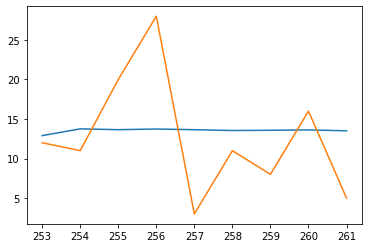

In [12]:
fcst.fcst.plot()
test.Deaths.plot()
plt.show()

In [13]:
comparison = pd.DataFrame()
comparison['Actual'] = list(test.Deaths.values)
comparison['Prediction'] = list(round(fcst.fcst))
comparison

,Actual,Prediction
0,12.0,13.0
1,11.0,14.0
2,20.0,14.0
3,28.0,14.0
4,3.0,14.0
5,11.0,14.0
6,8.0,14.0
7,16.0,14.0
8,5.0,14.0


In [14]:
# Define a function to calculate MAE and RMSE
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score

errors = comparison['Actual'] - comparison['Prediction']
mse = np.square(errors).mean()
rmse = np.sqrt(mse)
mae = np.abs(errors).mean()
mape = np.abs(errors/comparison['Actual']).mean() * 100
r2 = r2_score(comparison['Actual'], comparison['Prediction'])

In [15]:
print('Mean Absolute Error: {:.4f}'.format(mae))
print('Mean Squared Error: {:.4f}'.format(mse))
print('Root Mean Square Error: {:.4f}'.format(rmse))
print('Mean Absolute Percentage Error: {:.4f}'.format(mape))
print('R2 Score: {:.4f}'.format(r2))

Mean Absolute Error: 6.1111
Mean Squared Error: 54.7778
Root Mean Square Error: 7.4012
Mean Absolute Percentage Error: 86.3384
R2 Score: -0.0271


### Prophet Modelling

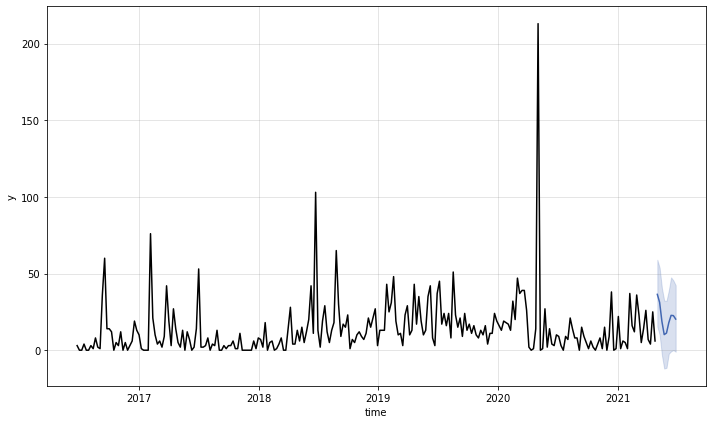

In [16]:
# import the param and model classes for Prophet model
from kats.models.prophet import ProphetModel, ProphetParams

# create a model param instance
params = ProphetParams(seasonality_mode='multiplicative') # additive mode gives worse results

# create a prophet model instance
m = ProphetModel(_ts, params)

# fit model simply by calling m.fit()
m.fit()

# make prediction for next 30 month
fcst = m.predict(steps=9, freq="1W")

# plot to visualize
m.plot()

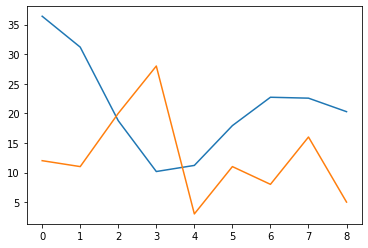

In [17]:
fcst.fcst.plot()
test.reset_index().Deaths.plot()
plt.show()

In [18]:
comparison = pd.DataFrame()
comparison['Actual'] = list(test.Deaths.values)
comparison['Prediction'] = list(round(fcst.fcst))
comparison

,Actual,Prediction
0,12.0,36.0
1,11.0,31.0
2,20.0,19.0
3,28.0,10.0
4,3.0,11.0
5,11.0,18.0
6,8.0,23.0
7,16.0,23.0
8,5.0,20.0


### Evaluation Metrics

In [19]:
# Define a function to calculate MAE and RMSE
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score

errors = comparison['Actual'] - comparison['Prediction']
mse = np.square(errors).mean()
rmse = np.sqrt(mse)
mae = np.abs(errors).mean()
mape = np.abs(errors/comparison['Actual']).mean() * 100
r2 = r2_score(comparison['Actual'], comparison['Prediction'])

In [20]:
print('Mean Absolute Error: {:.4f}'.format(mae))
print('Mean Squared Error: {:.4f}'.format(mse))
print('Root Mean Square Error: {:.4f}'.format(rmse))
print('Mean Absolute Percentage Error: {:.4f}'.format(mape))
print('R2 Score: {:.4f}'.format(r2))

Mean Absolute Error: 12.7778
Mean Squared Error: 212.5556
Root Mean Square Error: 14.5793
Mean Absolute Percentage Error: 145.8508
R2 Score: -2.9854


### Another way to do it!

In [23]:
from kats.utils.backtesters import BackTesterSimple
from kats.models.arima import ARIMAModel, ARIMAParams
backtester_errors = {}

params = ARIMAParams(p=2, d=1, q=1)
ALL_ERRORS = ['mape', 'smape', 'mae', 'mase', 'mse', 'rmse']

backtester_arima = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=_ts,
    params=params,
    train_percentage=75,
    test_percentage=25, 
    model_class=ARIMAModel)

backtester_arima.run_backtest()

backtester_errors['arima'] = {}
for error, value in backtester_arima.errors.items():
    backtester_errors['arima'][error] = value

ALL_ERRORS = ['mape', 'smape', 'mae', 'mase', 'mse', 'rmse']
params_prophet = ProphetParams(seasonality_mode='multiplicative') # additive mode gives worse results

backtester_prophet = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=_ts,
    params=params_prophet,
    train_percentage=75,
    test_percentage=25, 
    model_class=ProphetModel)

backtester_prophet.run_backtest()

backtester_errors['prophet'] = {}
for error, value in backtester_prophet.errors.items():
    backtester_errors['prophet'][error] = value

In [24]:
pd.DataFrame.from_dict(backtester_errors)

,arima,prophet
mape,inf,inf
smape,1.006801,1.090278
mae,15.917720,19.445872
mase,1.411571,1.724445
mse,807.147907,924.763843
rmse,28.410349,30.409930


## Reference

* https://github.com/facebookresearch/Kats/blob/master/tutorials/kats_201_forecasting.ipynb